In [2]:
# First we start loading our favourite packages with the names we used to
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
# import regression package
import statsmodels.api as sm

# Robustness of Quantitative Strategies




* The more complicated a trading strategy, the more the in sample results are often a poor guide to how things behave out of sample

* Looking for large t-stats only partially guard against that because you will be searching for things that have high t-stats and you are bound to find high t-stat strategies **in sample** even if no true large alpha strategy exists.

* the literature on the biases that the "strategy discovery" process creates is vast and growing

**Literature**

* [False (and Missed) Discoveries in Financial Economics](https://faculty.fuqua.duke.edu/~charvey/Research/Published_Papers/P143_False_and_missed_OL.pdf)

* [Predicting Anomaly Performance with Politics, the Weather, Global Warming, Sunspots, and the Stars](http://rnm.simon.rochester.edu/research/PPiCToAPA.pdf) by Rober Novy Marx

* [A comprehensive look at the empirical performance of equity premium prediction](https://academic.oup.com/rfs/article-abstract/21/4/1455/1565737)

Inspecting whether your discovery is **TRUE** or just a statistical abnormality is science as much as it is art. 

Patterns that are so statistically reliable that everyone can easily detect are unlikely to stay for long unless it is compensation for true risk. 

So you are unlikely to find something that makes sense only based on the stats and you will need to use your **economic logic** to evaluate if you cna understand why the premium is as high as it is. We will discuss this less "quantitative" part of the process in the chapter Equilibrium Thinking.

Here we will highlight the problem and discuss a few statistical techniques.

Here are a few Twitter threads from people in the industry about this

* [someone tells you they have a strategy with a Sharpe of S. What questions should you be asking about the strategy to verify that it's real?](https://twitter.com/macrocephalopod/status/1359810769433616384)

* [overfiting](https://twitter.com/macrocephalopod/status/1362165448205295620?s=20)

It has this really nice plot

![outofsample](../../assets/plots/outofsample1.jpg)


> What does it tell us?

* [The dumbest strategy ever created](https://imarketsignals.com/2021/outperforming-the-sp-500-with-50-consensus-stock-holdings-of-40-large-hedge-funds/)

* [We are always looking for patterns, be careful!](https://twitter.com/nope_its_lily/status/1368623837961621505)

## The basic problem of overfitting

Any sample estimate  is itself a random variable.  The uncertainty in these estimates may encourage us to:
- Select signals that are pure noise with no real predictive power.
- Select real signals but overweight their importance to the model.
- Reject signals that are real but that did not show up in the sample.
- Make inaccurate assessments of strategy quality and poor resource allocation.
- When choosing model weights, implicitly and explicitly (through optimization) we assign weights that exaggerate the overfitting problem.
- Weights tilt toward signals with the most error. Leading to bigger degradation in out-of-sample performance going forward.


## Suggestions to guard against overfitting


- Additional diagnostics
- Robustness tests
- Estimation/validation/Out of Sample analysis
- Optimization?
- Simulations? 

## Optimization makes it worse

- It is a form of in-sample regression.  
- Weights in model heavily determined by in-sample statistics, often the most extreme weights most likely to be off




## Additional Diagnostics

- Strategy Sharpe Ratio
- Report t-stat of mean return
- Alpha and t-stat of alpha
- Confidence intervals around key results including SR
- Strategy performance with small perturbations ( say change horizon, skip a month)
- Cumulative return  and drawdown graphs
    - where the performance is coming form? Is it steady? When it does poorly?
- Report percentage of observations with +/- 3 std events
- Remove “influential data points”: Calculate fraction of data points needed to halve estimated Sharpe ratio.
- When comparing Strategies, always do it over the same sample period!




### Confidence intervals/T-tests for Sharpe Ratios

- If returns are normal

$$\sigma(SR)=\sqrt{\frac{1}{T-1}(1+SR^2/2)}$$

where T is the sample size and SR is the estimated Sharpe Ratio

> what are the 95% Confidence intervals?

### Distribution sampling

- Instead of assuming returns have a particular distribution we can sample from the realized distribution to obtain alternative realization of the world 

**Bootstrap**
    - Draw from the data with replacement T times. This gives you a "new sample".
    - Construct The sharpe ratio in this sample, save it
    - Do that M times and compute the standard deviation of the SR across samples
    - You can also directly look at the 5% worse realizations
    - This give you the different SR that can be produced by the same truth




### Adjusting for Discarded Signals

- Often we look at many signals to find the one
- This makes conventional thresholds for t-tests too small
- There are many different adjustments for this

Boferroni T-stats

![Bonferroni Correction](../../assets/plots/bonferroni.jpg)


- You go form 1.96 to 3 as you look at 20 signals instead of 1
- It is a pretty conservative adjustment
- Correction changes the most as you go from 1 to 5 signals



### Robustifying your Backtests

- Calculate out of sample Sharpe ratios: Have a hold-out sample not used in backtest to test out of sample performance. 

- Be careful to not use out of sample results for tunning and model choice

- When tuning/model choice is needed it is useful to have

    - Estimation
    - Test sample
    - Hold out sample


- Add random noise to signals (some fraction of vol.) to slightly distort rankings and recompute Sharpe.
- How robust are slight perturbations in the cross-sectional rankings?

- Calculate the Sharpe ratio for a strategy that always eliminates the top 2% long and short positions (which are most likely error prone).

- Keep track of your discarded ideas going forward

- You need to calibrate your discovery process to be tough, but not too tough. Otherwise you will discard too many good signals.







## Approaches for sample splliting

- Rolling window estimation

- Use odd months to estimate signals and even months to compute returns and test signals.  Repeat by switching odd and even months.  

- Split sample in half, estimation and test sample

Be very careful for information of the test sample to leak into the estimation.

For example, your idea might be motivated by a few months where you know these firms did well. Be sure to check the results are not driving by this


**Aplication 1: optimal combitation of market and value strategies**

Below is our full sample optimal portfolio

We will split our sample into two halves:  
 1. take all observations from odd months in even years and even months in odd years (i.e., if starting in 1980, this would look like:  01/1980, 03/1980, . . . , 11/1980, 02/1981, 04/1981, . . . 12/1981, 01/1982, 03/1982, . . .); and 
 2.  the opposite (take all observations from even months in even years and odd months in odd years).

A nice thing to do in halves is that we can cross-validated  use first sample 1 as estiamtion sample and sample2 as test sample, and then invert

If you have lot of data one migh split the data in 5 folds and do the estimation in one and test on the rest.


In [3]:
# loading the data
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web
ds_names=get_available_datasets()
from datetime import datetime
start = datetime(1926, 1, 1)
ds = web.DataReader(ds_names[0], 'famafrench',start=start)
df=ds[0][:'2021-3']
df

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07,2.96,-2.56,-2.43,0.22
1926-08,2.64,-1.17,3.82,0.25
1926-09,0.36,-1.40,0.13,0.23
1926-10,-3.24,-0.09,0.70,0.32
1926-11,2.53,-0.10,-0.51,0.31
...,...,...,...,...
2020-11,12.47,5.80,2.09,0.01
2020-12,4.63,4.89,-1.51,0.01
2021-01,-0.03,7.36,3.01,0.01


In [4]:
# lets define a function to calculate the Sharpe ratio  
def SR(R,freq=12):
    sr=R.mean()/R.std()*freq**0.5
    return sr

In [6]:
Assets=df[['Mkt-RF','HML']]
Cov=Assets.cov()
ER=Assets.mean()
Vol_mkt=df['Mkt-RF'].std()
X=ER@np.linalg.inv(Cov)
# formula for unlevereaged portfolio vol
vol_unlevered=(ER@np.linalg.inv(Cov)@ER)**0.5
X_lev=X*(Vol_mkt/vol_unlevered)

Returns= Assets @ X_lev
SR(Returns)

0.49973547632746695

Can you construct the 95% Confidence interval for this Sharpe Ratio?

- Formula based answer
- Bootstrap based answer

Letss construct both samples by using a function that returns `True` if the number is odd and then apply this function to the months and years of our dataset.

In [7]:
# construct function that identifies if a number is odd
def is_odd(num):
    return num % 2 != 0

# create a sample that selects the even years and odd months
evenyear_oddmonth=(is_odd(df.index.year)==False) & (is_odd(df.index.month)==True)
# create a sample that selects the odd years and even months
oddyear_evenmonth=(is_odd(df.index.year)==True) & (is_odd(df.index.month)==False)
# join the two samples
sample1=evenyear_oddmonth | oddyear_evenmonth
# creates the mirror sample
sample2=~sample1

Lets construct a function that takes the sample and returns the SR

In [10]:
# function gets data and sample and returns the returns of the strategy 
def Strategy(df,sample):
   
    X=df[sample].mean()@np.linalg.inv(df[sample].cov())
    vol_unlevered=(df[sample].mean()@np.linalg.inv(df[sample].cov())@df[sample].mean())**0.5
    X_lev=X*(df['Mkt-RF'][sample].std()/vol_unlevered)

    Returns= df[~sample] @ X_lev
    return Returns

In [11]:



print('Optimal portfolio perfomance in sample 2 (estimation sample 1)')
print(SR(Strategy(df[['Mkt-RF','HML']],sample1)))
print('Market perfomance in sample 2')
print(SR(df[['Mkt-RF']][sample2]))
print('Optimal portfolio perfomance in sample 1 (estimation sample 2)')
print(SR(Strategy(df[['Mkt-RF','HML']],sample2)))
print('Market perfomance in sample 1')
print(SR(df[['Mkt-RF']][sample1]))


Optimal portfolio perfomance in sample 2 (estimation sample 1)
0.5389590626921715
Market perfomance in sample 2
Mkt-RF    0.502805
dtype: float64
Optimal portfolio perfomance in sample 1 (estimation sample 2)
0.452846286456286
Market perfomance in sample 1
Mkt-RF    0.38695
dtype: float64


* What do we learn?

Lets modify our function to include the estimation of the alpha relative to the market

Lets wrap this in a function that computes this for us


In [13]:
def Analysis(df,sample):
    results=pd.Series([],index=[],dtype=float)
    Returns=Strategy(df,sample)
    results.at['Strategy:SR']=SR(Returns)
    results.at['Strategy:std']=Returns.std()*12**0.5
    results.at['MKT:SR']=SR(df[~sample]['Mkt-RF'])
    results.at['MKT:std']=df[~sample]['Mkt-RF'].std()*12**0.5
    # now run the regression
    x= sm.add_constant(df[~sample]['Mkt-RF'])
    regresult= sm.OLS(Returns,x).fit()
    results.at['alpha']=regresult.params[0]
    results.at['t(alpha)']=regresult.tvalues[0]
    
    return results
print('Results for  test sample 2 (estimation sample 1)')
print(Analysis(Assets,sample1))
print('Results for  test sample 1 (estimation sample 2)')
Analysis(Assets,sample2)

Results for  test sample 2 (estimation sample 1)
Strategy:SR      0.538959
Strategy:std    18.232429
MKT:SR           0.502805
MKT:std         18.066091
alpha            0.168324
t(alpha)         1.438795
dtype: float64
Results for  test sample 1 (estimation sample 2)


Strategy:SR      0.452846
Strategy:std    18.831038
MKT:SR           0.386950
MKT:std         18.989794
alpha            0.153165
t(alpha)         1.681847
dtype: float64

* what do we learn?

* What other diagnostics can you add to this function?

* would it make sense to compute alpha with respect to the Fama-French 3 factor model--which includes HML as one of the factors?



## How to split your sample?

* You can split the sample in a variety of ways. 

* If you are unsure, keep  it simple. 

* The most fool proof way of splitting is with a rolling-sample approach

* You don't need to split the samples equally, but you have to have in mind that a long sample is useful to both get precise point estimates (so you need a long enough estimation sample), but a long sample is also required to have enough power to test. IF you make the test sample too short, you are guarantying that you will fail to reject your reference portfolio (because estimates will be too  noisy)



**Application 2: fine-tuning the look-back window**

Now we will compare a variety of models to see which one works best outside of the test sample

So we will have the estimation sample where we will estimate the different models-- which in this case will be strategies with different look-back windows

What is a look-back window?

- It is the window the we use to estimate our moments

The trade-off here is:

 - If you make too short you just pick up noise
 - If you make too long the moments might not be that informative about future data
 - Particularly true in he case of volatility, but also true for correlations and expected returns
- Particularly severe when dealing with individual assets and not characteristic-based strategies
 
 We will split the sample in two. 
 
 - The first half will be estimation+test, 
 
 - second half will be hold out
 
 

In [14]:
holdout_sample=df.index>df.iloc[int(np.floor(df.shape[0]/2))].name


* We will now do the estimation fine-tuning. 

- Lets start by building a code that gets our desired window, do the estimation and construct the return series on the test sample


<AxesSubplot:xlabel='Date'>

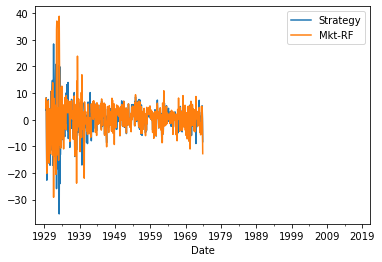

In [18]:


window=36
Returns_testsample=pd.DataFrame([],index=df.index,dtype=float)
# Use data that is not in the holdout sample to estimate the strategy
df1=Assets[~holdout_sample].copy()
# loop over the test sample
for d in df1.index[window:]:
    # select the first 36 months of the sample ( and then add one more month at the tail and drop the last month on the head each time we loop over the sample)
    df_temp=df1[d-window:d-1].copy()
    # construct optimal portfolio given these 36 months
    W1=df_temp.mean()@np.linalg.inv(df_temp.cov())
    vol_unlevered=(df_temp.mean()@np.linalg.inv(df_temp.cov())@df_temp.mean())**0.5
    W_lev=W1*(df_temp.std()/vol_unlevered)
    # save the returns of the strategy and the market on the FOLLOWING month
    # this month does NOT enter the estimation of the strategy
    Returns_testsample.at[d,'Strategy']= df1.loc[d] @ W_lev
    Returns_testsample.at[d,'Mkt-RF']= df1.loc[d,'Mkt-RF']

    
Returns_testsample.plot()


- Note that we have no observations early on as we need at the 36 months to estimate and none in the second half, that is the sample that we will hold out

- Now that we have this code we can put ina function and simply evaluate at a whole unch of different windows

<AxesSubplot:xlabel='Date'>

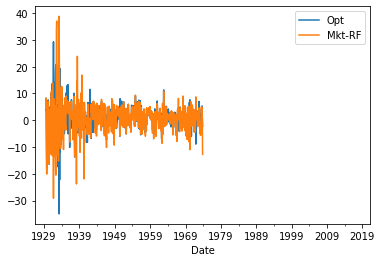

In [159]:
def RollingEval(df,window,estsample):
    Returns_test=pd.DataFrame([],index=df.index,dtype=float)
    df1=df[['Mkt-RF','HML']][estsample].copy()
    for d in df1.index[window:]:
        df_temp=df1[d-window:d-1].copy()
        W1=df_temp.mean()@np.linalg.inv(df_temp.cov())
        vol_unlevered=(df_temp.mean()@np.linalg.inv(df_temp.cov())@df_temp.mean())**0.5
        W_lev=W1*(df_temp.std()/vol_unlevered)
        Returns_test.at[d,'Opt']= df1.loc[d] @ W_lev
        Returns_test.at[d,'Mkt-RF']= df1.loc[d,'Mkt-RF']
    return Returns_test

Returns_test=RollingEval(df,36,sample1)        
Returns_test.plot()


In [162]:
windows=[24,36,48,60,72]
results=pd.DataFrame([],index=[],columns=windows,dtype=float)
for w in windows:
    Returns_test=RollingEval(df,w,sample1)    
    results.at['Optimal:SR',w]=SR(Returns_test.Opt)
    results.at['Optimal:std',w]=Returns_test.Opt.std()*12**0.5
    results.at['MKT:SR',w]=SR(Returns_test['Mkt-RF'])
    results.at['MKT:std',w]=Returns_test['Mkt-RF'].std()*12**0.5
    # now run the regression
    x= sm.add_constant(Returns_test['Mkt-RF'])
    y= Returns_test.Opt.copy()
    regresult= sm.OLS(y,x,missing='drop').fit()
    results.at['alpha',w]=regresult.params[0]
    results.at['t(alpha)',w]=regresult.tvalues[0]
    
results

,24,36,48,60,72
Optimal:SR,0.729121,0.662446,0.559205,0.613927,0.604021
Optimal:std,18.261577,17.478699,17.143940,16.599580,14.608167
MKT:SR,0.376006,0.349442,0.395631,0.442297,0.599587
MKT:std,21.156627,21.225400,20.875629,20.531663,19.393643
alpha,1.168284,0.956486,0.690608,0.703350,0.426639
t(alpha),5.165939,4.350827,3.221188,3.379011,2.449945


From this it seems that 24 looks best.

We will now look at how the 24 performed in the **Hold out sample**

In [163]:
windows=[24]
results=pd.DataFrame([],index=[],columns=windows,dtype=float)
for w in windows:
    Returns_test=RollingEval(df,w,sample2)    
    results.at['Optimal:SR',w]=SR(Returns_test.Opt)
    results.at['Optimal:std',w]=Returns_test.Opt.std()*12**0.5
    results.at['MKT:SR',w]=SR(Returns_test['Mkt-RF'])
    results.at['MKT:std',w]=Returns_test['Mkt-RF'].std()*12**0.5
    # now run the regression
    x= sm.add_constant(Returns_test['Mkt-RF'])
    y= Returns_test.Opt.copy()
    regresult= sm.OLS(y,x,missing='drop').fit()
    results.at['alpha',w]=regresult.params[0]
    results.at['t(alpha)',w]=regresult.tvalues[0]
    
results

,24
Optimal:SR,1.093922
Optimal:std,13.521201
MKT:SR,0.545364
MKT:std,15.462008
alpha,0.989791
t(alpha),6.354080


* Even better!

* That is pretty good

* you can see the t-stat goign through the roof and the SR of the optimal portfolio is almost twice as large as only investing in the market

* Note that here the bulk of the gains are form **Timing across these factors**. 

* You might also look to time between cash and this optimal portfolio

* The idea would be exactyl the same. You get a signal for the expected return and/or volatiltiy of the optimal portfolio
   - You already have one here, but the fact that the 24 months worked great to time across factors does not mean that it will work great to time between the factor and cash
   - But you would have some way to decide the weigths perhaps based on the mean-variance criteria, see how it works in the test sample across a variety of signal specifications and then you would ultimaterly test on the hold out sample
   
   

## Publication bias (or Famous bias or incubation bias...)

We discussed that we often look at past performance exactly because a strategy did well. This mechanism of selection renders our statistical analysis biased in the direction of findings that the strategy is amazing.

It is often hard to deal with this because you need all the data of strategies that look like the one you are interested from the perspective of someone in the start of the reliant sample. That is hard.

One way to deal with this is to use some hard metric of saliency. 

- For example, check when Bitcoin became popular and we did our analysis after that.

- See when a fund manager became well known because of his/her performance. While google trends is only available after 2004 there is data from New York Times and Wall Street Journal that allows you to go back to the start of the **Last** century. ([for example, I use data like that that in this paper](http://www.google.com/url?q=http%3A%2F%2Fwww.sciencedirect.com%2Fscience%2Farticle%2Fpii%2FS0304405X16301751&sa=D&sntz=1&usg=AFQjCNFWO63SSQXSteNhgTI4oOhtmh0ZUQ))

A setting where we can do this very cleanly is in the context of academic work. We know exactly when the paper was first published and what the sample that was used there

A nice paper that investigates this for a bunch of strategies is [Does academic research destroy stock return predictability?](https://onlinelibrary.wiley.com/doi/pdf/10.1111/jofi.12365?casa_token=gSqvouNM61EAAAAA:JyTl4yxx9xTfKo8-VEBIE-4c4ha7kRFGvirWzEZRXhYw2AtueM3yzpRDcpcXgnsDdlvlXflKp1Nw_ss)

**Application: Evaluating the publication bias in Fama French 1996, Multifactor Anomalies...**

The original paper has the following table


![outofsample](../../assets/plots/outofsample2.jpg)

* You see here that the sample runs from 63 to 93. Back in 93 we didn't have digitalized accounting data that went back to the 30's

* Looking at the very last row we see that the alpha of the HML withresepect to the market is enormous, 0.56% per month, and it has a negative beta with the market!

* so now we will look at two different samples that the authors never looked before doing their study.

    * The pre 63 sample
    * the post 93. 
    
    


In [169]:
sample1=df.index<df.loc['1963-7'].name
sample2=df.index>df.loc['1993-12'].name
sample3=((df.index>=df.loc['1963-7'].name) &(df.index<=df.loc['1993-12'].name))

In [179]:
def Strategy(df1,sample):
    results=pd.Series([],index=[],dtype=float)
    x= sm.add_constant(df1[sample]['Mkt-RF'])
    y= df1[sample]['HML'].copy()
    regresult= sm.OLS(y,x).fit()
    results.at['HML:SR']=SR(y)
    results.at['MKT:SR']=SR(df1[sample]['Mkt-RF'])
    results.at['alpha']=regresult.params[0]
    results.at['beta']=regresult.params[1]
    results.at['t(alpha)']=regresult.tvalues[0]
    results.at['AR']=regresult.tvalues[0]/regresult.resid.std()
    W=df1[sample].mean()@np.linalg.inv(df1[sample].cov())
    W=W/np.sum(W)
    results.at['HML weight on MVE']=W[1]

    return results
print('Pre publication sample')
print(Strategy(df[['Mkt-RF','HML']],sample1))
print('Publication sample')
print(Strategy(df[['Mkt-RF','HML']],sample3))
print('Post publication sample')
print(Strategy(df[['Mkt-RF','HML']],sample2))


Pre publication sample
HML:SR               0.346962
MKT:SR               0.457366
alpha                0.113160
beta                 0.371094
t(alpha)             0.661317
AR                   0.185219
HML weight on MVE    0.342709
dtype: float64
Publication sample
HML:SR               0.608203
MKT:SR               0.325699
alpha                0.542778
beta                -0.207224
t(alpha)             4.257801
AR                   1.755981
HML weight on MVE    0.696805
dtype: float64
Post publication sample
HML:SR               0.079270
MKT:SR               0.580553
alpha                0.113256
beta                -0.054502
t(alpha)             0.637514
AR                   0.201533
HML weight on MVE    0.228248
dtype: float64


**what do we learn?**

* In the Pre-publication sample HML has a respectable SR, but the asset is much more correlated with the market so it's betas with respect to the market leaves only a statistically insignifcant 0.37% per month, 1.2% per year.

* Thus in the pre-sample the HML has a nice SR but the CAPM works so you would not have gained/lost too much of tilting your portfolio towards the HML strategy

* In the post-publication sample the results are very ugly
    - Sharpe ratio is now 0.08--compared with the 0.58 SR on the market
    - the alpha is still about the same as in the pre-publication, but now the betas become negative
    - the HML premium goes away almost completely
    
    
To have a sense of the shift we can look at the risk-return trade-off of the market and HML across samples.
 
* The optimal weight on HML shifts from 0.72 in the publication sample to 0.34 in the pre publication and 0.2 in the post publication

* someone that jsut invested on the market would be actually be closer to the optimal portfolio than someone that invested 0.7 in HML

**Does that mean it was data snooping?**

We don't know. It is possible that the publication drove people to the strategies which made the resuls go away goign forward. This [paper](https://onlinelibrary.wiley.com/doi/pdf/10.1111/jofi.12365?casa_token=gSqvouNM61EAAAAA:JyTl4yxx9xTfKo8-VEBIE-4c4ha7kRFGvirWzEZRXhYw2AtueM3yzpRDcpcXgnsDdlvlXflKp1Nw_ss) I cited before argues that this is the case 



 